Hunter Bennett | Glass Lab | Kupffer Strains Project | 14 March 2023

Notebook for cis trans analysis of F0 NSG transplant RNA-seq data

### Import packages, set plotting parameters

In [1]:
# header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
%matplotlib inline
### imports ###
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns

Set working directory

In [2]:
workingDirectory = '/home/h1bennet/strains_github/results/Figure4/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

Define custom functions

In [3]:
def import_homer_diffgene(depath, gepath, gene_name_index=False):
    '''This function takes in a getDiffExpression file created from raw RNA counts
       and a gene expression file created with analyzeRepeates (tpm, ge, etc)
       and processes the files so that they contain the same set of genes and can be
       used for data visualization and analysis
       Accepts:
           depath (str): path to getDiffExpression file
           gepath (str): path to analyzeRepeats file
       Returns:
           de (pandas.DataFrame): modified getDiffExpression file
           ge (pandas.DataFrame): modified analyzerepeatsFile,
           ge_mat (pandas.DataFrame): analyzeRepeates file without annotation
           ge_mat_quatn (pandas.DataFrame) : analyzeRepeats file without annotation
           and quantile normalized
       '''
    # import packages
    import pandas as pd
    import numpy as np
    
    # import differential gene expression
    de = pd.read_csv(depath, sep='\t', index_col=0)
    de.index.rename('RepeatID', inplace=True)
    
    # import ge file
    ge = pd.read_csv(gepath, sep='\t', index_col=0)
    ge.index.rename('RepeatID', inplace=True)
    
    # select ge transcripts that are in diff_gene
    print('ge all transcripts', ge.shape)
    print('Diff Gene selected transcripts', de.shape)
    ge = ge.loc[de.index.tolist(), :]
    print('ge selected transcripts', ge.shape)
    
    if gene_name_index:
        # set index as gene
        ge['gene'] = ge['Annotation/Divergence'].str.split('|').str[0]
        de['gene'] = de['Annotation/Divergence'].str.split('|').str[0]

        # create gene name index
        ge = ge.reset_index().set_index('gene')
        de = de.reset_index().set_index('gene')

        # subset count matrix
        ge_mat = ge.iloc[:, 8:]
    else:
        # subset count matrix
        ge_mat = ge.iloc[:, 7:]

    # return files
    return (de, ge, ge_mat)

In [4]:
#### PLOTTING PARAMETERS FOR MANUSCRIPT ####
# # get matplotlib to save readable fonts
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['savefig.dpi'] = 500


# line widths
matplotlib.rcParams['axes.linewidth'] = 1
matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1

# adjust defualt color for plots to black
# normal default is a dark gray
COLOR = 'black'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
matplotlib.rcParams['axes.edgecolor'] = COLOR

#### PLOT PARAMETERS FOR THIS PLOT ####

# Cis/trans analysis

For this analysis we define *cis* regulated transcripts as those that are differentially expressed in a strain specific manner in both the F1 hybrid and the F0 parental strains at **a particular p-value and fold change threshold**.

we define *trans* regulated transcripts as those that are differentially expressed in a strain specific manner in the F0 parental strain but not the F1 hybrid at **a particular p-value and fold change threshold**.

we define *mixed* regulated transcripts as those that are differentially expressed in a strain specific manner in the F1 hybrid strain but not the F0 parental strain at **a particular p-value and fold change threshold**.

This approach gives us greater confidence in our estimate of biased allelic expression of a particular transcript, as there is some variance in the relative average expression.

Read in F0 parental differential gene expression

In [5]:
diff_gene_control, tpm_control, tpm_mat_control = import_homer_diffgene(
    './balbcj_control.vs.c57bl6j_control.deseq.txt',
    './rna_f1f0_tpm_mat.txt')

ge all transcripts (23608, 20)
Diff Gene selected transcripts (7667, 7)
ge selected transcripts (7667, 20)


Read in F1-NSG hybrid differential expression

In [6]:
diff_gene_NSG, tpm_NSG, tpm_mat_NSG = import_homer_diffgene(
    './balbcj_f1nsg_variants.vs.c57bl6j_f1nsg_variants.deseq.txt',
    './rna_f1f0_tpm_mat.txt')

ge all transcripts (23608, 20)
Diff Gene selected transcripts (3345, 7)
ge selected transcripts (3345, 20)


Merge differential gene files, drop any genes that are present in one file but not the other, as these genes cannot be confidently determined to be cis or trans regulated

In [7]:
df = diff_gene_control.merge(diff_gene_NSG,
                             suffixes=['_p1', '_f1'],
                             left_index=True,
                             right_index=True,
                             how='outer')

df = df.dropna(how='any')
df.shape

(2743, 14)

Set fold change and p value thresholds

In [8]:
fc = np.log2(2)
padj = 0.05

In [9]:
parental_balb = (df['log2FoldChange_p1'] < -fc) & (df['padj_p1'] < padj)
f1_balb = (df['log2FoldChange_f1'] < -fc) & (df['padj_f1'] < padj)
parental_c57 = (df['log2FoldChange_p1'] > fc) & (df['padj_p1'] < padj)
f1_c57 = (df['log2FoldChange_f1']  > fc) & (df['padj_f1'] < padj)

cis_balb = parental_balb & f1_balb
trans_balb = parental_balb & (~f1_balb)
mixed_balb = (~parental_balb) & (f1_balb)
cis_c57 = parental_c57 & f1_c57
trans_c57 = parental_c57 & (~f1_c57)
mixed_c57 = (~parental_c57) & (f1_c57)

In [10]:
lists = [cis_balb, trans_balb, mixed_balb,
         cis_c57, trans_c57, mixed_c57]
labels = ['cis_balb_filt_pval', 'trans_balb_filt_pval', 'mixed_balb_filt_pval',
          'cis_c57_filt_pval', 'trans_c57_filt_pval', 'mixed_c57_filt_pval']

# set color palette
pal = matplotlib.cm.get_cmap('rocket')
colors = [pal(0.6), pal(0.4), pal(0.2),
          pal(0.6), pal(0.4), pal(0.2)]

# create legend objects
n_cis = cis_balb.sum() + cis_c57.sum()
n_trans = trans_balb.sum() + trans_c57.sum()
n_mixed = mixed_balb.sum() + mixed_c57.sum()
n_same = df.shape[0] - (n_cis + n_trans + n_mixed)

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0],
                          marker='o', color='w',
                          label='Same: %i' % n_same,
                          markerfacecolor=pal(0.99),
                          markersize=3),
                   Line2D([0], [0],
                          marker='o', color='w',
                          label='Cis: %i' % n_cis,
                          markerfacecolor=pal(0.6),
                          markersize=3),
                   Line2D([0], [0],
                          marker='o', color='w',
                          label='Trans: %i' % n_trans,
                          markerfacecolor=pal(0.4),
                          markersize=3),
                   Line2D([0], [0],
                          marker='o', color='w',
                          label='Mixed: %i' % n_mixed,
                          markerfacecolor=pal(0.2),
                          markersize=3)]

Make plot

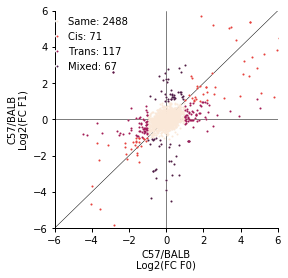

In [11]:
fig, ax = plt.subplots(figsize=(4,4))

# plot bounding lines
ax.plot([-10,10], [-10,10], c='k',
        linewidth=0.5, zorder=1)
ax.axhline(0, c='k', linewidth=0.5,
           zorder=1)
ax.axvline(0, c='k', linewidth=0.5,
           zorder=1)

ax.scatter(df.log2FoldChange_p1,
           df.log2FoldChange_f1,
           s=1,
           c=[pal(0.99)],
           zorder=2)

for genelist, color in zip(lists, colors):
    ax.scatter(df.loc[genelist, 'log2FoldChange_p1'],
               df.loc[genelist, 'log2FoldChange_f1'],
               s=1,
               c=[color],
               zorder=3)
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_xticklabels([])

ax.set_xlabel('C57/BALB\nLog2(FC F0)')
ax.set_ylabel('C57/BALB\nLog2(FC F1)')

ax.legend(handles=legend_elements,
          frameon=False, ncol=1, loc=(-0.05,0.7),
          handletextpad=0.05, columnspacing=0.05)

ax.set_xlim([-6,6]);
ax.set_ylim([-6,6]);


Write out gene lists

In [12]:
if not os.path.isdir('./gene_lists/'):
    os.mkdir('./gene_lists')

for label, genelist in zip(labels, lists):
    with open('./gene_lists/f1nsg_kupffer_'+label+'.txt', 'w') as f:
        f.write('Gene\n')
        for i in genelist.index[genelist].tolist():
            f.write(i+'\n')
        f.close()